# Binary Classification of Sentences

### Importing Necessary Libraries

TensorFlow framework is used to build the Binary Classification Model. Scikit-Learn provides us the metrics for the evaluation purpose.

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score

## Data

The model is trained on the following very small amount of fabricated data.

In [2]:
sentences = [
    'you won a billion dollars , great work !',
    'click here for cs685 midterm answers',
    'read important cs685 news',
    'send me your bank account info asap'
]
labels = tf.cast(np.array([1, 1, 0, 1]), dtype=tf.float32)

Metal device set to: Apple M1 Max


2022-09-02 14:00:56.390700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-02 14:00:56.390820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data Preparation

We set the word embedding dimension and maximum number of tokens allowed per sequence below. We use the `Tokenizer` from TensorFlow for tokenization and padding the sentences. We set the vocabulary size to $9999 + 1$ most frequent words and the CLS token. Since, the Max length of tokenized sentences is set to $10$, CLS token is assigned the id $10000$.

In [3]:
EMBED_DIM = 128 # The word embedding dimension
MAX_LEN = 10 # The max length of the sentences
VOCAB_SIZE = 10000 # Vocabulary Size
CLS_TOKEN = VOCAB_SIZE # In this case we assign CLS_TOKEN to token ID 10000

Tokenization of the sentence makes token embedding possible. We keep the embedding layer trainable here and don't use any pre-trained word embeddings. A large training set would generate optimal and reliable word embedding for the classification task.

In [4]:
# Initializing Tokenizer, with the last id reserved for [CLS]
tokenizer = tf.keras.preprocessing.text.Tokenizer(VOCAB_SIZE-1)
# Training Tokenizer on training data
tokenizer.fit_on_texts(sentences)
# Tokenized and converted to ids
train_data = tokenizer.texts_to_sequences(sentences)
train_data = [[CLS_TOKEN] + seq for seq in train_data]
# Post padding and post truncating the sequence 
train_data = tf.keras.utils.pad_sequences(train_data, maxlen=MAX_LEN, truncating='post', padding='post')
train_data = tf.cast(train_data, dtype=tf.float32)

## Model Building

## Task-1

The following are the model parameters

In [5]:
POS_ENC_ANGLE_DENO = 10000 # Denominator angle in Positional Encoding
NUM_ENC_LAYERS =  2 # Number of Encoder Blocks or Layers
NUM_HEADS =  2 # Number of heads
EMBED_DIM = 100 # Embedding Dimension
FEED_FORWARD_DIM = 32 # Feed Forward NNs number of units in hidden layer
DROPOUT_RATE = 0.1 # Dropout Rate
MAX_LEN = 10 # Max length of each tokenized sentence
BATCH_SIZE = 4 # Training Batch Size
EPOCHS = 10 # Number of epochs to train model

We calculate the positional encoding for each word vector using,
$$PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})$$
where, $2i$, $2i+1$ is the index in the column of the word embedding vector and $pos$ is the position of the word in the padded tokenized sequence.

In [6]:
def pos_enc(max_len, d_model):
    # returns the positional encoding matrix which needs to be added to the embedding matrix
    angles = np.arange(max_len)[:, np.newaxis] / np.power(POS_ENC_ANGLE_DENO, 2*(np.arange(d_model)[np.newaxis, :]//2/np.float32(d_model)))
    pos_encode = np.zeros((max_len, d_model))
    pos_encode[:, 0::2] = np.sin(angles[:, 0::2])
    pos_encode[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.cast(pos_encode[np.newaxis, :], dtype=tf.float32)

We calculate the padding mask which is basically the same as the original padding mask just that it has $2$ extra dimensions to make up for the dimension corresponding to the heads and embedding vector length in the heads.

In [7]:
def pad_mask(mat):
    # recasts the sequence with little different dimensions and generates padding mask
    mask = tf.cast(tf.math.equal(mat, 0), dtype=tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

We compute the attention score of each word with the other word using the query vector, key vector and value vector for each word which when stacked forms the $Q$, $K$ and $V$ matrices. The attention vector (stacked to form attention matrix) is calculated using the scaled dot product attention formula given by,
$$Attention(Q,K,V) = softmax_k(\frac{QK^T}{\sqrt{d_k}})V$$

In [8]:
def scaled_dot_prod_attn(q, k, v, mask):
    # returns the scaled dot product attention based on queries, keys and values and mask
    qk = tf.matmul(q, k, transpose_b=True) # calculates the numerator of the softmax input
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    pre_softmax = qk / tf.sqrt(dk) # calculates the angle input into softmax
    if mask is not None:
        pre_softmax += (mask * 1e-9) # padding mask as softmax would give almost zero for these positions
    attn_wts = tf.nn.softmax(pre_softmax, axis=-1) # attention weights per word for other words
    final_attention = tf.matmul(attn_wts, v) # value vectors weighted average with attention weights
    return final_attention

Now, the Q, K and V matrix are linearly transformed to learn the nature of queries, keys and values across various representations in different subspace. For each of these representations the attentions are calculated as mentioned above in the different heads and these are then stacked together to be passed to the next layers.

In [9]:
class MHA(tf.keras.layers.Layer):
    # class for multi-head attention
    def __init__(self, *, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0 # checks if split of d_model is position among heads
        self.d_head = self.d_model // self.num_heads
        
        self.linear_q = tf.keras.layers.Dense(self.d_model)
        self.linear_k = tf.keras.layers.Dense(self.d_model)
        self.linear_v = tf.keras.layers.Dense(self.d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def div_heads(self, dat, batch_size):
        dat = tf.reshape(dat, (batch_size, -1, self.num_heads, self.d_head))
        return tf.transpose(dat, perm=[0, 2, 1, 3])
    
    def call(self, V, K, Q, mask):
        batch_size = tf.shape(Q)[0]
        
        # Linear Transformation for different representation in different heads
        Q = self.linear_q(Q)
        K = self.linear_k(K)
        V = self.linear_v(V)
        
        # split K, Q, V matrix among heads
        q = self.div_heads(Q, batch_size)
        k = self.div_heads(K, batch_size)
        v = self.div_heads(V, batch_size)
        
        # calculate the scaled dot product in each head
        scaled_attn = scaled_dot_prod_attn(q, k, v, mask)
        scaled_attn = tf.transpose(scaled_attn, perm=[0, 2, 1, 3])
        # concatenate the attention vectors from each head
        concat_attn = tf.reshape(scaled_attn, (batch_size, -1, self.d_model)) 
        
        final_output = self.dense(concat_attn)
        return final_output

After the attentions are being calculated, we need some non-linearity in our model as uptil now we had no source of non-linearity in our model. That is where we pass these attention vectors generated from MHA is passed through the Feedforward Neural Network.

In [10]:
def post_MHA_FF_Net(d_model, d_ff):
    # returns the post MHA feed forward neural network
    FF_Net = tf.keras.Sequential([
        tf.keras.layers.Dense(d_ff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])
    return FF_Net

Now, the above computation i.e. Multi-Headed Attention followed by Feed Forward Neural Network (with skip connections across both MHA and Feed Forward part) forms a single layer/block of the Encoder part of a Transformer.

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    # returns the model where MHA, skip connection, batch norm and feed forward network, skip connection and batch norm is added
    def __init__(self, *, d_model, num_heads, num_nodes, drop_rate=0.1):
        super().__init__()
        
        self.mha = MHA(d_model=d_model, num_heads=num_heads)
        self.ffn = post_MHA_FF_Net(d_model, num_nodes)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(drop_rate)
        self.dropout2 = tf.keras.layers.Dropout(drop_rate)
        
    def call(self, x, train, mask):
        # calculating the multi head attention
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=train)
        output1 = self.layernorm1(x + attn_output) # skip connection
        
        # feeding the concatenated attention matrix output of MHA into Feed-Forward Network
        ffn_output = self.ffn(output1)
        ffn_output = self.dropout2(ffn_output, training = train)
        final_output = self.layernorm2(x + ffn_output) # skip connection
        return final_output

We repeat the Encoder Block twice, as decided in our parameter after the positional encoding is added to the word embedding matrix to build the final Encoder part of the Transformer.

In [12]:
class Encoder(tf.keras.layers.Layer):
    # returns model which takes the embeddings as input along with mask and adds positional encoding 
    # and 2 encoder blocks
    def __init__(self, *, num_layers, vocab_size, embed_dim, d_model, max_len, num_heads, num_nodes, drop_rate=0.1):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.d_model = d_model
        self.max_len = max_len
        self.num_layers = num_layers
        self.pos_encoding = pos_enc(MAX_LEN, self.d_model)
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, input_length=max_len)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, num_nodes=num_nodes, drop_rate=drop_rate)
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(drop_rate)
        
    def call(self, x, train=True):
        sent_len = tf.shape(x)[1]
        mask = pad_mask(x) # creating padding mask
        x *= tf.math.sqrt(tf.cast(self.d_model, dtype=tf.float32))
        x = self.embedding(x) # trainable word embeddings
        x += self.pos_encoding[:, :sent_len, :] # adding positional encoding
        
        x = self.dropout(x, training=train)
        # passing the embedded and position encoded data through 1st encoder layer and the output is passed through
        # another encoder layer
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, train, mask)
        
        return x

Now, as mentioned earlier the model inputs are going to be the sequence of token ids.

In [13]:
input1 = tf.keras.layers.Input(shape=(MAX_LEN,)) # Sequence of token ids as input with padding upto MAX_LEN
transformer = Encoder(
    num_layers=NUM_ENC_LAYERS, 
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    d_model=EMBED_DIM, 
    max_len=MAX_LEN,
    num_heads=NUM_HEADS, 
    num_nodes=FEED_FORWARD_DIM, 
    drop_rate=DROPOUT_RATE
)

The Encoder block learns a feature vector for each word which assists the classification. For classification we take the representation vector output by transformer for the CLS token. This concise vector is now passed through another feed forward neural network with dropouts and finally is hooked up with a $2$ neuron output layer with softmax activation. Where the first neuron corresponds to the predicted probability of the sentence belonging to the label $0$ and the second neuron corresponds to that for the label $1$.

In [14]:
# For classification we take the CLS representation from the transformer and feeds them into the following
# feed forward network for classification
x = transformer(input1, True)
x = x[:, 0, :] # Extracting the output feature vector for the [CLS] token i.e. 10000 token id
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
x = tf.keras.layers.Dense(FEED_FORWARD_DIM, activation='relu')(x) # Feed Forward Network for classification
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x) # 0th unit corresponds to label 0 and 1st unit to label 1

In [15]:
model = tf.keras.Model(inputs=input1, outputs=output)

The following summarizes our model.

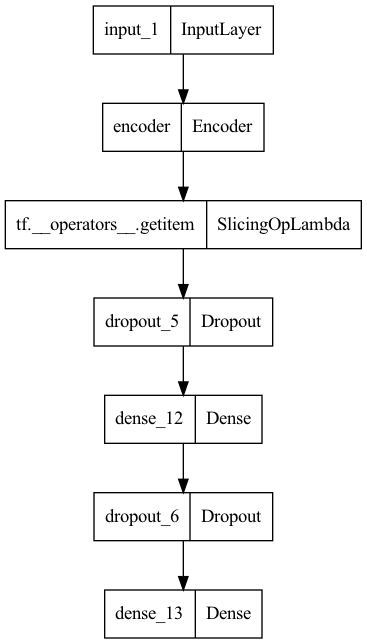

In [16]:
tf.keras.utils.plot_model(model)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 encoder (Encoder)           (None, 10, 100)           1094664   
                                                                 
 tf.__operators__.getitem (S  (None, 100)              0         
 licingOpLambda)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                3232      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                             

The model is trained using the Adam Optimizer and the loss function chosen is the sparse categorical crossentropy as the true labels are scaler numbers. Batch Size of $4$ was used and the model was trained for $10$ epochs.

In [18]:
# Training Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data, labels, batch_size=BATCH_SIZE, epochs=EPOCHS
)

Epoch 1/10


2022-09-02 14:00:57.141009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-02 14:00:57.891168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.4237 - accuracy: 0.7500
Epoch 2/10
1/1 [==============================] - 0s 32ms/step - loss: 0.8229 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 20ms/step - loss: 0.5966 - accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 0s 24ms/step - loss: 0.4253 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 21ms/step - loss: 0.9058 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 22ms/step - loss: 0.6854 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 22ms/step - loss: 0.6857 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 22ms/step - loss: 0.5769 - accuracy: 0.5000
Epoch 9/10
1/1 [==============================] - 0s 20ms/step - loss: 0.6085 - accuracy: 0.7500
Epoch 10/10
1/1 [==============================] - 0s 21ms/step - loss: 1.1029 - accuracy: 0.7500


### Evaluation

We generate the prediction probabilities from the above trained model.

In [19]:
pred_class_probs = model.predict(train_data) # Model Predictions

1/1 [==============================] - 0s 391ms/step


2022-09-02 14:00:58.887708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The probability of each sentence being label 0 or 1 as output by model is shown below.

In [20]:
pred_class_probs # The probability of the sentences being label 0 or label 1

array([[0.1075457 , 0.8924543 ],
       [0.12181864, 0.87818134],
       [0.05293028, 0.94706976],
       [0.06887323, 0.93112683]], dtype=float32)

We take the index of the maximum of the two predicted probabilities for each sentence to be the predicted label of that sentence.

In [21]:
pred_labels = np.argmax(pred_class_probs, axis=-1) # Model output is maximum of the two probabilities

It can be seen that the model predicts with accuracy $0.75$ all the labels. But ofcourse our model is not well trained due to very small training data and the model performance on train data only is unreliable estimate of the actual model performance.

In [22]:
pred_labels

array([1, 1, 1, 1])

The precision score, recall score and the F1 score is reported below.

In [23]:
print("*** Model Performance ***")
print("Precision Score:", precision_score(labels, pred_labels))
print("Recall Score:", recall_score(labels, pred_labels))
print("F1 Score:", f1_score(labels, pred_labels))

*** Model Performance ***
Precision Score: 0.75
Recall Score: 1.0
F1 Score: 0.8571428571428571


## Task-2

We will now simply use the transformer architechture constructed step-by-step ahead and will increase the number of heads to $10$.

In [24]:
NUM_HEADS = 10 # Number of heads increased to 10

In [25]:
input1 = tf.keras.layers.Input(shape=(MAX_LEN,)) # Sequence of token ids as input with padding upto MAX_LEN
transformer = Encoder(
    num_layers=NUM_ENC_LAYERS, 
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    d_model=EMBED_DIM, 
    max_len=MAX_LEN,
    num_heads=NUM_HEADS, 
    num_nodes=FEED_FORWARD_DIM, 
    drop_rate=DROPOUT_RATE
)

In [26]:
# For classification we take the CLS representation from the transformer and feeds them into the following
# feed forward network for classification
x = transformer(input1, True)
x = x[:, 0, :] # Extracting the output feature vector for the [CLS] token i.e. 10000 token id
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
x = tf.keras.layers.Dense(FEED_FORWARD_DIM, activation='relu')(x) # Feed Forward Network for classification
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x) # 0th unit corresponds to label 0 and 1st unit to label 1

In [27]:
model = tf.keras.Model(inputs=input1, outputs=output)

tf.keras.utils.plot_model(model)

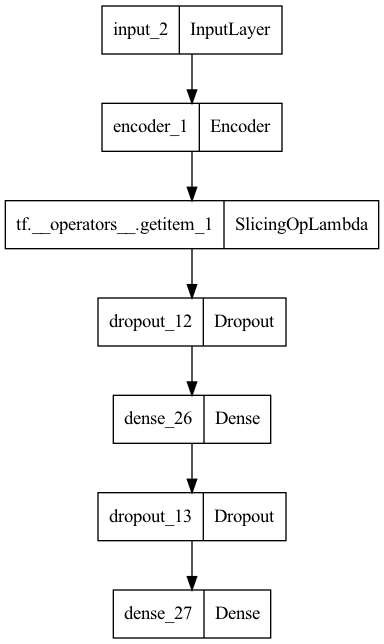

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 encoder_1 (Encoder)         (None, 10, 100)           1094664   
                                                                 
 tf.__operators__.getitem_1   (None, 100)              0         
 (SlicingOpLambda)                                               
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 32)                3232      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                           

In [36]:
# Training Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data, labels, batch_size=BATCH_SIZE, epochs=EPOCHS
)

Epoch 1/10


2022-09-02 14:02:45.816078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.5839 - accuracy: 0.7500
Epoch 2/10
1/1 [==============================] - 0s 24ms/step - loss: 0.5798 - accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 0s 21ms/step - loss: 0.6178 - accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 0s 29ms/step - loss: 0.5721 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 51ms/step - loss: 0.5193 - accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 0s 23ms/step - loss: 0.8109 - accuracy: 0.7500
Epoch 7/10
1/1 [==============================] - 0s 20ms/step - loss: 0.5051 - accuracy: 0.7500
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 0.6034 - accuracy: 0.7500
Epoch 9/10
1/1 [==============================] - 0s 21ms/step - loss: 0.7403 - accuracy: 0.7500
Epoch 10/10
1/1 [==============================] - 0s 47ms/step - loss: 0.5181 - accuracy: 0.7500


### Evaluation

In [31]:
pred_class_probs = model.predict(train_data) # Model predictions

2022-09-02 14:01:01.197151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 437ms/step


In [32]:
pred_labels = np.argmax(pred_class_probs, axis=-1) # Model output is maximum of the two probabilities

In [33]:
pred_labels

array([1, 1, 1, 1])

In [34]:
print("*** Model Performance ***")
print("Precision Score:", precision_score(labels, pred_labels))
print("Recall Score:", recall_score(labels, pred_labels))
print("F1 Score:", f1_score(labels, pred_labels))

*** Model Performance ***
Precision Score: 0.75
Recall Score: 1.0
F1 Score: 0.8571428571428571
